In [3]:
#import networkx as nx
#from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
import itertools
import warnings
import argparse
from multiprocessing import Pool
import sys
from collections import Counter
import random
import pickle
import re
import networkx as nx
from os import listdir
import cupy as cp
from cupyx.scipy.sparse import csr_matrix as csr_gpu
import scipy
import matplotlib.colors as colors
from collections import defaultdict 
import pandas as pd
import os
from matplotlib.animation import FuncAnimation
sys.path.insert(0, "../../lib")  # add the library folder to the path I look for modules
import latexify
import dynamical_cavity

Choose the folder to load data from

In [4]:
dir_list = next(os.walk('.'))[1]# select only first subdirectories
folder_pattern = re.compile("gamma_[0-9]+")
folder_names=[name  for name in dir_list if folder_pattern.match(name)]# select only folder with specific names
pattern2 = re.compile("\d+.\d+|\d+")
matching_folders=[[n for n in pattern2.findall(folder)] for folder in folder_names]
print("Select one of this folder\ngamma")
for el in matching_folders:
    print(str(el[0]))
matching_folders

Select one of this folder
gamma
3
1.81


[['3'], ['1.81']]

In [14]:
'''
while True:
    gamma=input("Choose gamma ")
    if [gamma] in matching_folders:
        #gamma=int(gamma)
        break
    else:
        print("choose a different gamma ")
'''

'\nwhile True:\n    gamma=input("Choose gamma ")\n    if [gamma] in matching_folders:\n        #gamma=int(gamma)\n        break\n    else:\n        print("choose a different gamma ")\n'

In [5]:
gamma = 1.81
def load_obj(folder,name ):
    with open(folder+'/data/dic-' + name + '.pkl', 'rb') as f:
        return pickle.load(f)
def load_and_hist(T,gamma,**kwargs):
    dic=load_obj('gamma_'+str(gamma),"T_"+str(T)+"_theta"+str(theta))
    N=dic["N"]
    gamma=dic["gamma"]
    T=dic["T"]
    J=dic["J"]    
    magn_simulation=dic["magn_simulation"]# shape is N_replics,N1
    mean_sim=np.mean(magn_simulation,axis=0)
    magn_cavity=dic["magn_cavity"] #cavity(0,T, J, P_init)# take half temperature if things seems not to work
    h_dyn,b_dyn=np.histogram(mean_sim,**kwargs,density=True)
    h_cavity,b_cavity=np.histogram(magn_cavity,bins=b_dyn,density=True)
    #plot(bins[:-1],h_cavity,"-",mfc="w",label="cavity"+str(T))
    return b_dyn,h_dyn,h_cavity
folder="gamma_"+str(gamma)
filenames=listdir(folder+"/data")
pattern = re.compile("dic-T_\d*\.\d+|\d+theta_[0-9]+.pkl")
dictnames=[name  for name in filenames if pattern.match(name)]# select only dictionary files
pattern2 = re.compile("\d*\.\d+|\d+")
sim_params=[[n for n in pattern2.findall(dic)] for dic in dictnames]
print("Simulation available for")
print(pd.DataFrame(sim_params,columns=["T","theta"]).set_index("T").sort_index())
#for el in a:
#    print(str(el[0])+"  \t "+str(el[1])+" \t"+str(el[2]))


Simulation available for
    theta
T        
0.1   0.0
0.2   0.0
0.2   0.1


In [6]:
T=.2
theta = 0.1
dic=load_obj('gamma_'+str(gamma),"T_"+str(T)+"_theta"+str(theta))
N=dic["N"]
gamma=dic["gamma"]
T=dic["T"]
J=dic["J"]
try:
    N_iterations = dic['N_iterations']
except KeyError:
    N_iteration = 0
magn_simulation=dic["magn_simulation"]# shape is N_replics,N1
mean_sim=np.mean(magn_simulation,axis=0)
var_sim=np.var(magn_simulation,axis=0)
P_init=np.array([0.5]*N)
magn_cavity=dic["magn_cavity"] #cavity(0,T, J, P_init)# take half temperature if things seems not to work
N_replics = np.shape(magn_simulation)[0]

In [7]:
J_transpose = J.transpose().tolil()
js = J_transpose.rows  # list of list, structure is [el[i]] where el[i]

interaction = J_transpose.data  # list of list, structure is [el[i]]
Ks = np.array([len(neigh) for neigh in js])  # in degree of each gene

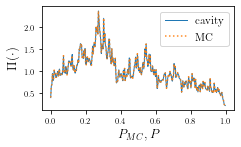

In [8]:
#figure(figsize=(4,3))
#bins=linspace(-0.01,1.01,50)
latexify.latexify(columns=2)

bins,h_dyn,h_cavity =load_and_hist(T,gamma,bins = 301)
#h_dyn,b_dyn=histogram(mean_sim,np.linspace(0,1,100),density=True)
#h_cavity,b_cavity=histogram(magn_cavity,bins=np.linspace(0,1,300),density=True)
plt.plot(bins[:-1],h_cavity,"-",lw = 1,alpha = 1,mfc="w",label="cavity")
plt.plot(bins[:-1],h_dyn,':',alpha = 0.9,lw = 1.5,label="MC")
#,density=True
#bar(bins[:-1],h_cavity/sum(h_cavity),width=diff(bins),align="edge",alpha=0.4,label="cavity")
plt.xlabel("$P_{MC},P$",fontsize =13)
plt.ylabel("$\\Pi(\cdot)$",fontsize =13)

plt.legend(fontsize =11,numpoints = 1,ncol= 1)
#plt.ylim(0.01,)
plt.tight_layout()
#plt.savefig(folder+"/T="+str(T)+".pdf")



In [11]:
mean_sim= magn_simulation

In [11]:
N_iterations,J.data
N

100000

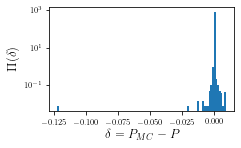

In [11]:
plt.hist(mean_sim-magn_cavity,100,density=True)
plt.semilogy()
#plt.xlabel('$\\delta = P_{sim}-P_{cav}$',fontsize = 13)
plt.xlabel('$\\delta = P_{MC}-P$',fontsize = 13)
plt.ylabel('$\\Pi(\\delta)$',fontsize = 13)
plt.tight_layout()
#plt.savefig('cav_vs_sim.pdf')

In [20]:
a = cavity.cavity_caller(J,T,theta = 0,J0 = 1)


finishing after 16 iterations


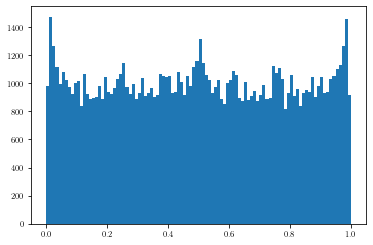

In [21]:
_ = plt.hist(a,100)

variation over different replicas are very small. Magnetisation depends on the site.

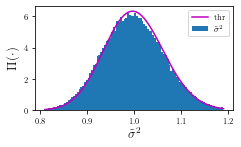

In [10]:
#N_iterations =max(log(1-0.9)/log(0.5*(1+tanh(1/2/T))),100)# number iterations grows at low temperature. See notes
#N_iterations = min(N_iterations, 1000) # we avoid N_iterations to explode at low T
s = var_sim/(magn_cavity*(1-magn_cavity)/N_iterations)/np.mean(var_sim/(magn_cavity*(1-magn_cavity)/N_iterations))
h,b = np.histogram(s,bins = np.linspace(1-3*np.sqrt(2/N_replics),1+3*np.sqrt(2/N_replics),100),density=True)#sample variance / threoretical
#h,b = np.histogram(var_sim/(magn_cavity*(1-magn_cavity)/N_iterations),bins = 100,density=True)#sample variance / threoretical

plt.bar(b[:-1],h,np.diff(b),label = '$\\tilde{\sigma}^2$')

xs = np.linspace(b[0],b[-1],500)
#plt.plot(xs,[stats.norm(loc=1,scale = np.sqrt(2/N_replics)).pdf(x) for x in xs],'k--',label = '$\\mathcal{N}(1,2/N_s)$')
plt.plot(xs,[N_replics*stats.chi2(df = N_replics).pdf(x*N_replics) for x in xs],'m',label = 'thr')
plt.xlabel("$\\tilde{\\sigma}^2$",fontsize = 13)
ylabel("$\\Pi(\\cdot)$",fontsize =13)
#plt.axvline(1,ls = '--',color = 'k')
plt.tight_layout()
plt.legend()
#plt.xlim(0,2)

#plt.semilogy()
#plt.savefig(folder+'/std_T='+str(T)+'.pdf')


# Hamming distance

In [20]:
def unique_initial_conditions(N_replics,N1):
    N_unique=1
    while True:
        if N_unique>=N_replics:
            break
        initial=np.unique(rand(N_replics,N)>0.5,axis=0)
        N_unique=len(initial)
    return where(initial,1,0)

def replics_parallel(J,N_replics):
    N = J.shape[0]
    '''Generates N_rep2.**max(Ks)lics iniital conditions. each of them are slightly perturbed and then the hammin distance over time is shown'''
    pool=Pool()
    try:
        if N_replics>0.1*2**N:
            initials=[list(p) for p in itertools.product([0,1], repeat=N)]
            raise Warning("I use 2**N replics instead")
        else:
            initials=unique_initial_conditions(N_replics,N)
    except OverflowError:
        initials=unique_initial_conditions(N_replics,N)
    data=pool.starmap(dynamics_parallel,itertools.product([J],[T],initials))
    #data=pool.starmap(dynamics_lowT,itertools.product([J],initials))
    #for replica in range(N_replic):
    #        data+=[dynamics_light(J,psi_init,T)]
    pool.close()
    return data

def dynamics_same_noise(J,T,n_start,proces = None):
        '''returns the Hamming distance between to trajectory with the same noise realisation'''
        N1=len(n_start)
        n=n_start
        t = 1
        N_therm = 100
        while t<N_therm:
            n = scipy.sparse.csr_matrix(n)
            z=numpy.random.logistic(0,T/2,(1,N1))
            #z=numpy.random.normal(0,T,(1,N1))
            a=(n*J).toarray()-z
            n=where(a>0,1,0)
            t+=1
        k=3# select the number of spin to flip 
        js=random.sample(range(N1),k)
        tau_start=n.copy()[0]
        for j in js:
            tau_start[j]=~tau_start[j]
        tau=scipy.sparse.csr_matrix(tau_start)
        n=scipy.sparse.csr_matrix(n)
        t=1
        data=[]
        '''
        while t<N_therm1:
            z=numpy.random.logistic(0,T/2,(1,N1))
            #z=numpy.random.normal(0,T,(1,N1))
            a=(n*J).toarray()-z
            n=where(a>0,1,0)
            n=scipy.sparse.csr_matrix(n)
            t+=1
        '''
        N_therm=100
        while t<N_therm:
            z=numpy.random.logistic(0,T/2,(1,N1))
            #z=numpy.random.normal(0,T,(1,N1))
            a=(n*J).toarray()-z
            b=(tau*J).toarray()-z
            n=where(a>0,1,0)
            tau=where(b>0,1,0)
            data+=[count_nonzero(tau!=n)]
            n=scipy.sparse.csr_matrix(n)
            tau=scipy.sparse.csr_matrix(tau)
            t+=1

        return data
def dynamics(J,T,n_start,N_therm,proces = None):
        '''returns the end state for a trajectory'''
        #local_state = np.random.RandomState(seed)
        N1=len(n_start)
        n=n_start
        t = 0
        while t < N_therm:
            z = cp.random.logistic(0, T , (1, N1))
            # z=numpy.random.normal(0,2*T,(1,N1))
            a = n * J - z
            n = cp.where(a > 0, 1, 0.)[0]
            t += 1
        return n

In [21]:
N = 10000
N_iterations = 10000
gamma = 3
T = 0.2
J = dyn.make_network(N,gamma)
J_gpu = csr_gpu(J)

In [50]:
N_replics = 1000
initials = unique_initial_conditions(N_replics,N)
#initials = [initials[0]]*N_replics
#pool = Pool()
sim = list(itertools.starmap(dynamics, itertools.product([J_gpu],[T],cp.asarray(initials),[N_replics])))
#pool.close()
P = dynamical_cavity.cavity_caller(J,T,0)

finishing after 15 iterations


In [48]:
int(cp.count_nonzero(list(zip(*itertools.combinations(sim,2)))[0][0]==list(zip(*itertools.combinations(sim,2)))[1][0]))

6672

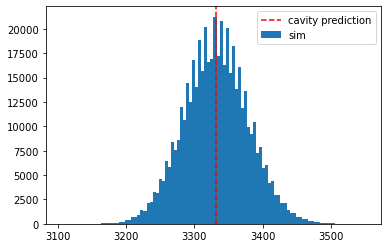

In [51]:
distances = list(map(lambda x,y: N-int(cp.count_nonzero(x==y)),*zip(*itertools.combinations(sim,2))))


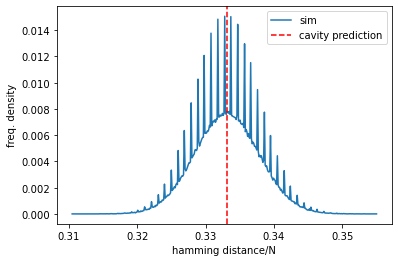

In [61]:
h,b = np.histogram(distances,400,density=True)
plt.plot(b[:-1]/N,h,label= 'sim')
plt.axvline(np.mean(2*P*(1-P)),color = 'r',ls = '--',label = 'cavity prediction')
plt.legend()
plt.xlabel('hamming distance/N')
plt.ylabel('freq. density')
#plt.savefig('hamming_dist.pdf')

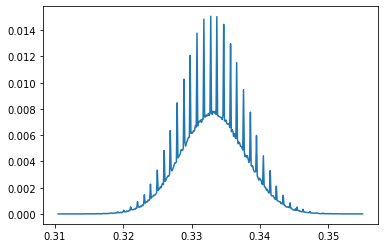

In [62]:
h,b = np.histogram(distances,400,density=True)
plt.plot(b[:-1]/N,h,label= 'sim')
plt.xlim(0.33,0.)

5000.0

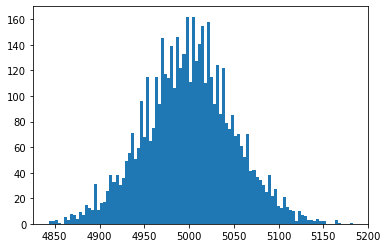

In [21]:
distances = list(map(lambda x,y: N-np.count_nonzero(x==y),*zip(*itertools.combinations(initials,2))))
_ = plt.hist(distances,100,label= 'sim')


6053.462704543866

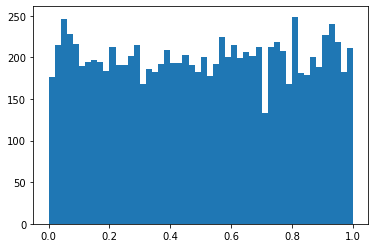

In [9]:
plt.hist(np.mean(sim,axis = 0),50)
#plt.hist(P,30)
sum(P**2+(1-P)**2)

In [52]:
x = np.random.rand(J.shape[0])
x_gpu = cp.array(x)
x_cpu = scipy.sparse.csr_matrix(x)

J

<1000x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 1775 stored elements in Compressed Sparse Row format>

In [58]:
a = (x_cpu * J).toarray()
b = cp.asnumpy(x_gpu*csr_gpu(J))


(array([1.000e+00, 8.755e+03, 0.000e+00, 8.310e+02, 0.000e+00, 2.580e+02,
        0.000e+00, 7.600e+01, 3.600e+01, 0.000e+00, 1.500e+01, 0.000e+00,
        1.000e+01, 0.000e+00, 9.000e+00, 0.000e+00, 1.000e+00, 2.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([ 0.  ,  0.56,  1.12,  1.68,  2.24,  2.8 ,  3.36,  3.92,  4.48,
         5.04,  5.6 ,  6.16,  6.72,  7.28,  7.84,  8.4 ,  8.96,  9.52,
        10.08, 10.64, 11.2 , 11.76, 12.32, 12.88, 13.44, 14.  , 14.56,
        15.12, 15.68, 16.24, 16.8 , 17.36, 17.92, 18.48, 19.04, 19.6 ,
        20.16, 20.72, 21.28, 21.84, 22.4 , 22.96, 23.52, 24.08, 24.64,
        25.2 , 25.76,

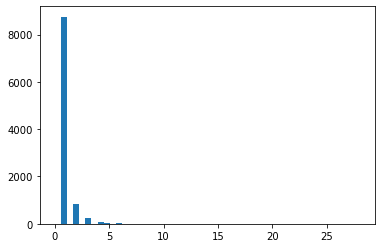

In [30]:
plt.hist([len(x) for x in J.tolil().rows],50)

In [42]:
data = itertools.starmap(dynamics_gpu, itertools.product([J], initial_states, [T], [N_iterations]))

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/opt/miniconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/miniconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([1.628e+03, 2.764e+03, 2.025e+03, 1.190e+03, 7.360e+02, 4.300e+02,
        3.030e+02, 2.100e+02, 1.520e+02, 1.500e+02, 8.300e+01, 7.000e+01,
        5.300e+01, 2.000e+01, 5.200e+01, 1.500e+01, 2.600e+01, 2.000e+00,
        1.200e+01, 0.000e+00, 3.400e+01, 0.000e+00, 0.000e+00, 0.000e+00,
        9.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.800e+01, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 2.000e+00]),
 array([ 0.        ,  0.44676616,  0.89353232,  1.34029847,  1.78706463,
         2.23383079,  2.68059695,  3.12736311,  3.57412926,  4.02089542,
         4.46766158,  4.91442774,  5.3611939 ,  5.80796005,  6.25472621,
         6.70149237,  7.14825853,  7.59502469,  8.04179085,  8.488557  ,
         8.93532316,  9.38208932,  9.82885548, 10.27562164, 10.72238779,
        11.

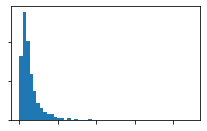

In [95]:
plt.hist(np.std(sim,axis = 0)/np.mean(sim,axis = 0),50)

In [23]:
np.count_nonzero(np.array(sorted(Ks,reverse=True))>200)

9

In [92]:
cp.asarray(list(itertools.starmap(lambda x:cp.random.rand(),itertools.product(range(1)))))

array([0.99225699])

In [31]:
sum(2**Ks)/1e18

1.2960471145315207

In [39]:
2.**max(Ks)

<ipython-input-39-53359a9cb9d7>:1: RuntimeWarning: overflow encountered in power
  2.**max(Ks)


inf

In [20]:
def load_obj(gamma,name):
    path='gamma_'+str(gamma)+'/dic-' + name + '.pkl'
    with open(path, 'rb') as f:
        return pickle.load(f)
    print("Couplings loaded from"+path)
dic = load_obj(gamma,"couplings")
dic['J'].shape

(50000, 50000)